--------------------
# Dynamic Difficulty Adaptation in Video Games
## Javier Cables Chozas
--------------------

## Introduction
Dynamic difficulty adaptation is a system that automatically adjusts the challenge of the game in real time according to the player's performance. Its goal is to keep the player in a “flow state” where the challenge matches his skill, avoiding frustration or boredom.

We will address this problem in two specific cases, using a different algorithm for each case.

On the one hand, we will see what algorithm we can use for automatic matching of players based on their level or skill in the game. This could be an approach for competitive online games, where fair and challenging matchmaking in games is indispensable.

On the other hand, we will use another algorithm to adjust the difficulty of an individual game based on the user's statistics and the currently applied difficulty level, to decide whether to maintain, decrease or increase it, in order to maintain the flow state during the game session.

In [1]:
import numpy as np
import pandas as pd

import os
os.environ["OMP_NUM_THREADS"] = "5"

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt

## Dataset
For this project, we have chosen to generate a dataset for the following reasons:
* Privacy and ethics: Real player data is usually protected by privacy regulations and is not freely accessible. 
* Control and flexibility: When creating the data, we can ensure that it includes the variables needed for the analysis and that it follows realistic statistical patterns 
, reflecting the diversity and typical behavior of the players.
* Reproducibility: A generated dataset allows anyone to reproduce our experiments and results, since the data are constructed with a fixed random seed. 
* Validation of algorithms: Before applying models in production, it is essential to test them on data that simulate real situations but without the risks associated with real information. 

Therefore, the dataset we have created is designed to mimic the structure, relationships and variability of a real dataset of players, facilitating the development, evaluation and improvement of artificial intelligence systems for difficulty adaptation in video games. 

In [2]:
np.random.seed(42)
n_players = 1200

skill_levels = ['Very Bad', 'Bad', 'Average', 'Good', 'Very Good']
skill_probs = [0.1, 0.2, 0.4, 0.2, 0.1]
skill_range = np.random.choice(skill_levels, size = n_players, p = skill_probs)

total_playtime_hours = np.random.gamma(shape = 2, scale = 50, size = n_players).astype(int)

level_achieved = (
    total_playtime_hours**0.5 * 10 +
    np.random.normal(0, 5, n_players) +
    (np.where(skill_range == 'Very Good', 5,
      np.where(skill_range == 'Good', 2,
      np.where(skill_range == 'Average', 0,
      np.where(skill_range == 'Bad', -2, -5)))))
).clip(1, 100).astype(int)

performance_metrics = {
    'Very Bad': {
        'win_rate_percentage': (30, 45),
        'avg_kills_per_match': (0.5, 2),
        'avg_deaths_per_match': (5, 10),
        'accuracy_percentage': (20, 40),
        'headshot_rate': (3, 10),
        'reaction_time_ms': (300, 400)
    },
    'Bad': {
        'win_rate_percentage': (40, 55),
        'avg_kills_per_match': (1, 3),
        'avg_deaths_per_match': (4, 8),
        'accuracy_percentage': (30, 50),
        'headshot_rate': (5, 15),
        'reaction_time_ms': (250, 350)
    },
    'Average': {
        'win_rate_percentage': (50, 65),
        'avg_kills_per_match': (2, 5),
        'avg_deaths_per_match': (3, 6),
        'accuracy_percentage': (40, 65),
        'headshot_rate': (10, 25),
        'reaction_time_ms': (200, 300)
    },
    'Good': {
        'win_rate_percentage': (60, 80),
        'avg_kills_per_match': (4, 7),
        'avg_deaths_per_match': (1, 4),
        'accuracy_percentage': (55, 80),
        'headshot_rate': (20, 35),
        'reaction_time_ms': (150, 250)
    },
    'Very Good': {
        'win_rate_percentage': (75, 95),
        'avg_kills_per_match': (6, 10),
        'avg_deaths_per_match': (0.5, 3),
        'accuracy_percentage': (70, 95),
        'headshot_rate': (30, 45),
        'reaction_time_ms': (120, 200)
    }
}

def generate_metrics(row):
    metrics = performance_metrics[row['skill_range']]
    return pd.Series({
        'win_rate_percentage': np.round(np.random.uniform(*metrics['win_rate_percentage']), 2),
        'avg_kills_per_match': np.round(np.random.uniform(*metrics['avg_kills_per_match']), 2),
        'avg_deaths_per_match': np.round(np.random.uniform(*metrics['avg_deaths_per_match']), 2),
        'accuracy_percentage': np.round(np.random.uniform(*metrics['accuracy_percentage']), 2),
        'headshot_rate': np.round(np.random.uniform(*metrics['headshot_rate']), 2),
        'reaction_time_ms': int(np.random.uniform(*metrics['reaction_time_ms']))
    })

metrics_df = pd.DataFrame({'skill_range': skill_range}).apply(generate_metrics, axis = 1)
metrics_df['kd_ratio'] = (metrics_df['avg_kills_per_match'] / metrics_df['avg_deaths_per_match']).round(2)

final_df = pd.DataFrame({
    'age': np.random.randint(13, 66, size = n_players),
    'gender': np.random.choice(['Male', 'Female', 'Other'], size = n_players, p = [0.6, 0.38, 0.02]),
    'country': np.random.choice(['USA', 'Spain', 'Germany', 'France', 'UK', 'Japan', 'Brazil',
                                'Australia', 'Canada', 'Mexico', 'Italy', 'Netherlands', 'Sweden',
                                'South Korea'], size = n_players),
    'total_playtime_hours': total_playtime_hours,
    'level_achieved': level_achieved,
    'matches_played': (total_playtime_hours * 2 + np.random.normal(0, 20, n_players)).clip(10, 1000).astype(int)
})
final_df = pd.concat([final_df, metrics_df], axis = 1)

# final_df.to_csv('players_data.csv', index = False)

In [3]:
df = pd.read_csv('players_data.csv')
df.head()

,age,gender,country,total_playtime_hours,level_achieved,matches_played,win_rate_percentage,avg_kills_per_match,avg_deaths_per_match,accuracy_percentage,headshot_rate,reaction_time_ms,kd_ratio
0,58,Female,Brazil,230,100,475,54.56,4.43,3.88,51.16,20.91,269.0,1.14
1,47,Female,Japan,79,92,130,94.75,6.90,2.16,85.24,43.73,132.0,3.19
2,60,Male,South Korea,20,46,71,75.04,5.70,1.82,66.86,25.01,207.0,3.13
3,27,Female,Brazil,33,54,65,63.34,3.71,4.90,52.97,10.77,223.0,0.76
4,19,Male,Brazil,137,100,279,47.38,1.62,4.73,40.08,8.23,275.0,0.34


## Exploratory Data Analysis

In [4]:
df['age'].value_counts()

age
27    45
64    33
60    32
29    31
15    30
50    30
61    29
22    28
62    27
35    27
21    27
43    26
20    26
54    26
56    26
41    25
46    25
31    25
57    25
26    24
38    24
14    24
18    24
13    24
58    24
52    23
36    23
25    23
40    23
39    23
19    23
30    22
16    22
33    21
53    21
65    21
17    20
59    19
48    19
55    19
47    18
32    18
63    18
34    18
24    17
42    17
37    15
44    14
45    13
51    12
23    11
49    11
28     9
Name: count, dtype: int64

__Age:__
Age of the player. It is a discrete numeric variable.

In [5]:
df['gender'].value_counts()

gender
Male      727
Female    442
Other      31
Name: count, dtype: int64

__Gender:__
Gender of the player. It is a categorical nominal variable (Male, Female, Other).

In [6]:
df['country'].value_counts()

country
Brazil         99
South Korea    98
Sweden         92
France         90
USA            90
Australia      88
UK             88
Mexico         85
Netherlands    82
Germany        82
Japan          81
Spain          78
Canada         75
Italy          72
Name: count, dtype: int64

__Country:__
Age of the player. It is a categorical nominal variable.

In [7]:
df['total_playtime_hours'].value_counts()

total_playtime_hours
71     12
46     12
69     12
64     11
29     11
       ..
267     1
275     1
225     1
253     1
242     1
Name: count, Length: 272, dtype: int64

__Total Playtime Hours:__ Total playing time (hours). It is a discrete numerical variable.

In [8]:
df['level_achieved'].value_counts()

level_achieved
100    500
92      19
87      19
83      18
79      18
      ... 
33       1
8        1
20       1
16       1
11       1
Name: count, Length: 86, dtype: int64

__Level Achieved:__ Level achieved (1-100). It is a discrete numerical variable.

In [9]:
df['matches_played'].value_counts()

matches_played
10     14
64      9
131     9
95      9
113     9
       ..
265     1
531     1
326     1
508     1
485     1
Name: count, Length: 441, dtype: int64

__Matches Played:__ Number of games played. It is a discrete numerical variable.

In [10]:
df['win_rate_percentage'].value_counts()

win_rate_percentage
64.04    4
64.84    4
52.03    4
63.43    3
60.30    3
        ..
76.27    1
62.47    1
57.03    1
42.31    1
40.77    1
Name: count, Length: 1050, dtype: int64

__Win Rate Percentage:__ Winning percentage. It is a continuous numerical variable.

In [11]:
df['avg_kills_per_match'].value_counts()

avg_kills_per_match
2.03    8
2.89    6
4.03    6
1.06    6
4.40    6
       ..
3.73    1
2.77    1
8.42    1
9.49    1
4.96    1
Name: count, Length: 580, dtype: int64

__Avg Kills per Match:__ Average number of casualties per game. It is a continuous numerical variable.

In [12]:
df['avg_deaths_per_match'].value_counts()

avg_deaths_per_match
3.58    7
4.00    7
5.57    7
5.63    6
2.83    6
       ..
4.51    1
7.38    1
8.57    1
4.95    1
0.52    1
Name: count, Length: 618, dtype: int64

__Avg Deaths per Match:__ Average number of deaths per game. It is a continuous numerical variable.

In [13]:
df['accuracy_percentage'].value_counts()

accuracy_percentage
46.63    3
56.01    3
37.73    3
43.93    3
63.46    3
        ..
90.55    1
30.20    1
93.30    1
92.34    1
35.89    1
Name: count, Length: 1076, dtype: int64

__Accuracy Percentage:__ Hit percentage per shot. It is a continuous numerical variable.

In [14]:
df['headshot_rate'].value_counts()

headshot_rate
14.80    4
24.67    4
6.16     4
12.00    4
14.11    4
        ..
41.54    1
12.46    1
37.95    1
14.72    1
12.63    1
Name: count, Length: 982, dtype: int64

__Headshot Rate:__ Percentage of head shot per shot. It is a continuous numerical variable.

In [15]:
df['reaction_time_ms'].value_counts()

reaction_time_ms
251.0    15
283.0    14
253.0    13
266.0    13
260.0    13
         ..
151.0     1
372.0     1
373.0     1
376.0     1
369.0     1
Name: count, Length: 260, dtype: int64

__Reaction Time MS:__ Reaction time in milliseconds (ms). It is a continuous numerical variable.

In [16]:
df['kd_ratio'].value_counts()

kd_ratio
0.43     19
0.19     17
0.62     16
0.17     15
0.69     13
         ..
2.30      1
6.40      1
12.59     1
17.49     1
3.79      1
Name: count, Length: 382, dtype: int64

__KD Ratio:__ Average casualty to kill ratio per game. If a player gets 10 kills and 5 kills in a game he will have a KD of 2.0 in that game. It is a continuous numerical variable.

In [17]:
print(df.describe())

              age  total_playtime_hours  level_achieved  matches_played  \
count  1200.00000           1200.000000     1200.000000     1200.000000   
mean     38.92000            101.391667       83.073333      202.661667   
std      15.76491             70.773399       20.655350      140.442897   
min      13.00000              1.000000        1.000000       10.000000   
25%      26.00000             49.000000       69.000000       99.000000   
50%      38.00000             86.000000       92.000000      176.500000   
75%      53.00000            134.000000      100.000000      272.000000   
max      65.00000            680.000000      100.000000     1000.000000   

       win_rate_percentage  avg_kills_per_match  avg_deaths_per_match  \
count          1200.000000          1200.000000           1200.000000   
mean             58.429675             3.786200              4.466633   
std              13.787617             2.145077              2.000359   
min              30.170000      

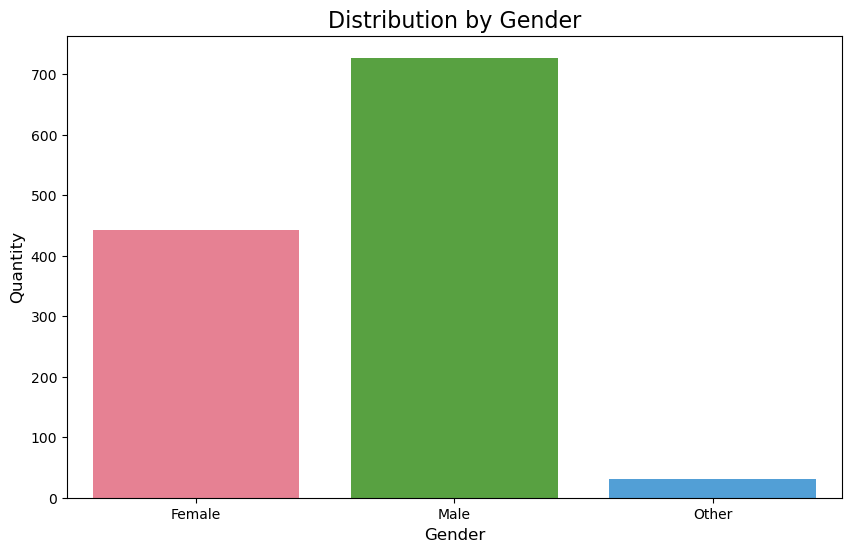

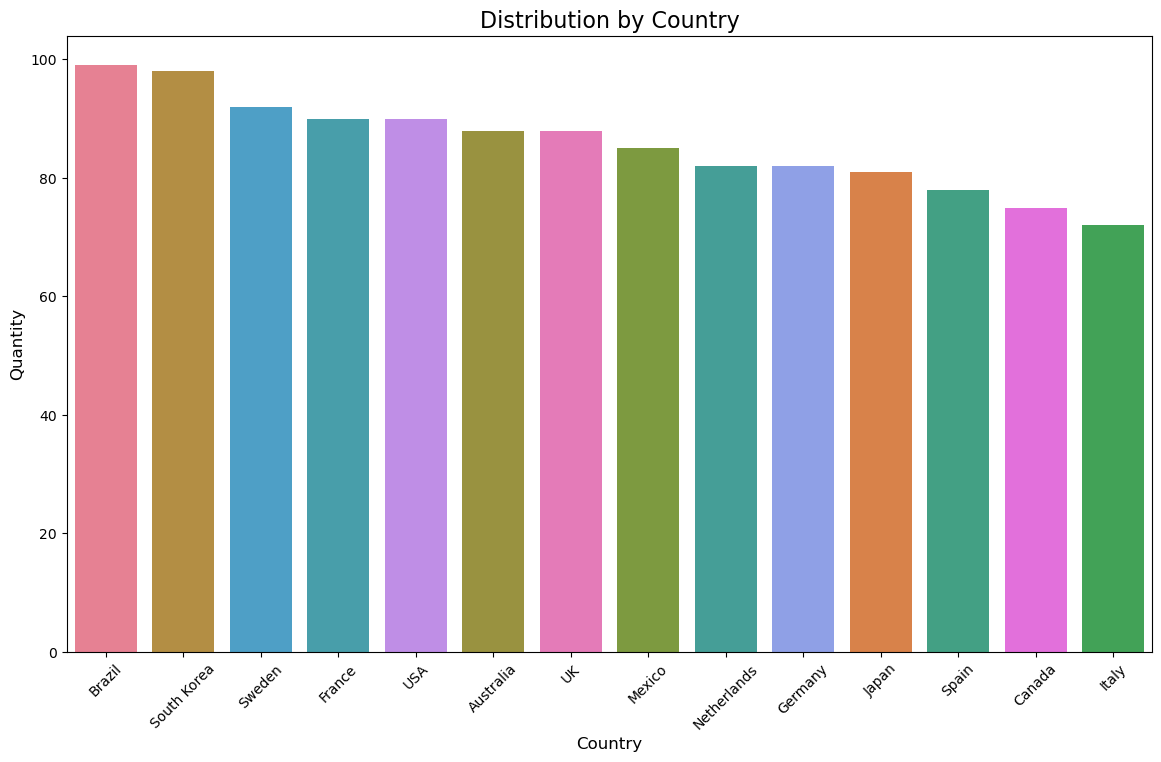

In [18]:
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'gender', hue = 'gender', palette = 'husl')
plt.title('Distribution by Gender', fontsize=16)
plt.xlabel('Gender', fontsize = 12)
plt.ylabel('Quantity', fontsize = 12)
plt.show()

plt.figure(figsize = (14, 8))
country_order = df['country'].value_counts().index
sns.countplot(data = df, x = 'country', hue = 'country', order = country_order, palette = 'husl')
plt.title('Distribution by Country', fontsize = 16)
plt.xlabel('Country', fontsize = 12)
plt.ylabel('Quantity', fontsize = 12)
plt.xticks(rotation = 45)
plt.show()

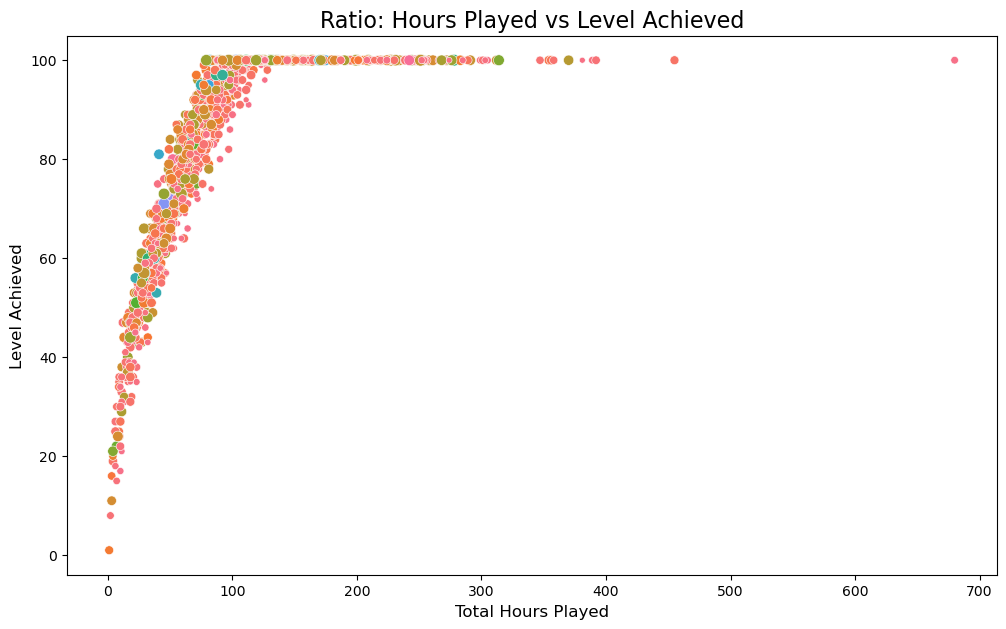

In [19]:
plt.figure(figsize = (12, 7))
sns.scatterplot(data = df, x = 'total_playtime_hours', y = 'level_achieved', 
                hue = 'kd_ratio', palette = 'husl', size = 'win_rate_percentage', legend = False)
plt.title('Ratio: Hours Played vs Level Achieved', fontsize = 16)
plt.xlabel('Total Hours Played', fontsize = 12)
plt.ylabel('Level Achieved', fontsize = 12)
plt.show()

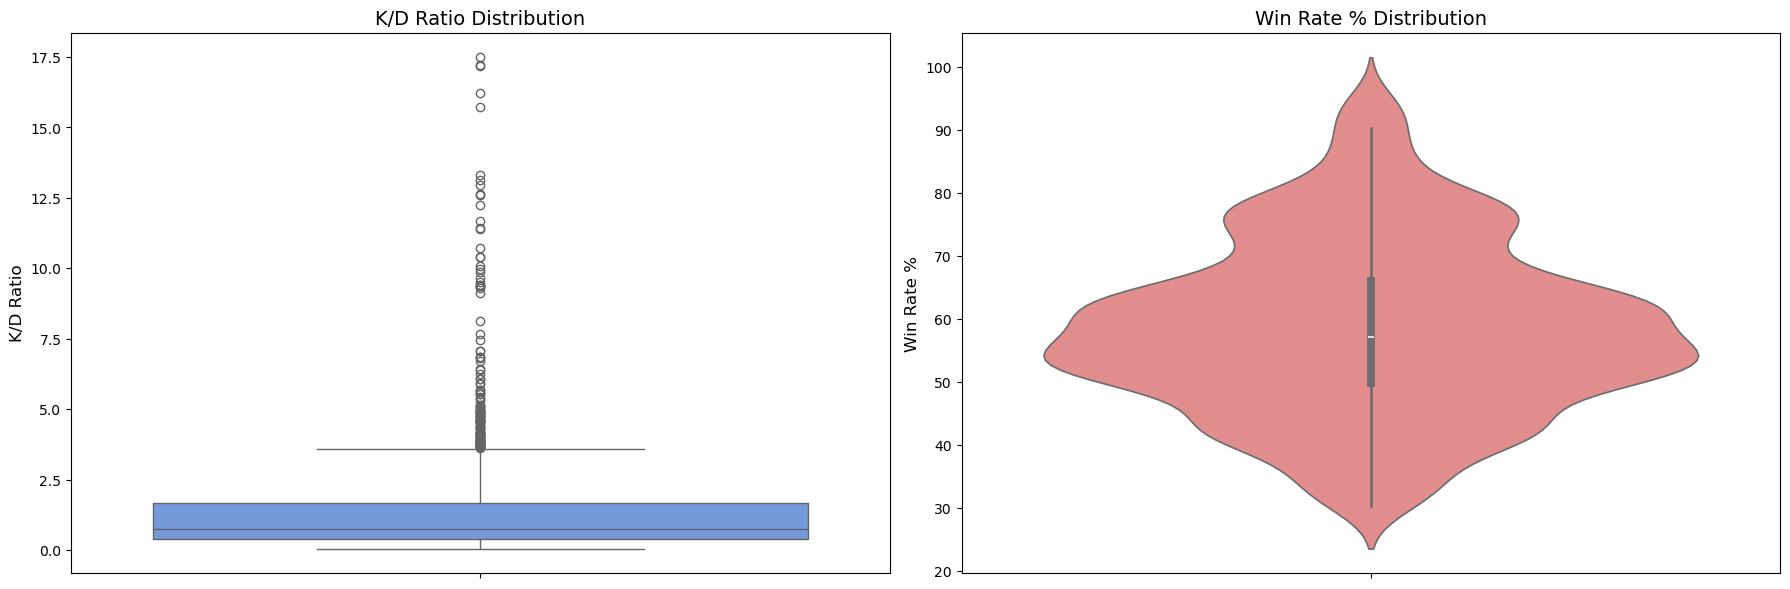

In [20]:
fig, axs = plt.subplots(1, 2, figsize = (18, 6))

sns.boxplot(data = df, y = 'kd_ratio', ax = axs[0], color = 'cornflowerblue')
axs[0].set_title('K/D Ratio Distribution', fontsize = 14)
axs[0].set_ylabel('K/D Ratio', fontsize = 12)

sns.violinplot(data = df, y = 'win_rate_percentage', ax = axs[1], color = 'lightcoral')
axs[1].set_title('Win Rate % Distribution', fontsize = 14)
axs[1].set_ylabel('Win Rate %', fontsize = 12)

plt.tight_layout()
plt.show()

<Figure size 1200x700 with 0 Axes>

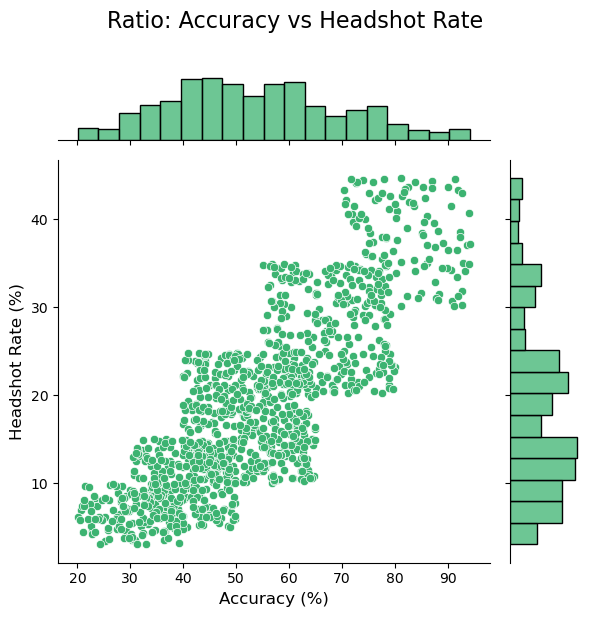

In [21]:
plt.figure(figsize = (12, 7))
sns.jointplot(data = df, x = 'accuracy_percentage', y = 'headshot_rate', 
              kind = 'scatter', color = 'mediumseagreen')
plt.suptitle('Ratio: Accuracy vs Headshot Rate', fontsize = 16, y = 1.02)
plt.xlabel('Accuracy (%)', fontsize = 12)
plt.ylabel('Headshot Rate (%)', fontsize = 12)
plt.tight_layout()
plt.show()

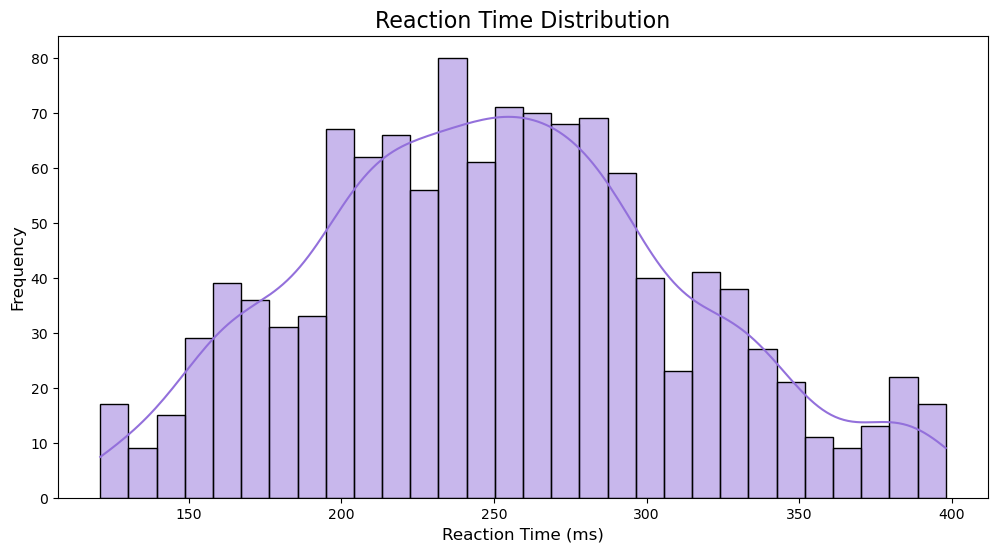

In [22]:
plt.figure(figsize = (12, 6))
sns.histplot(data = df, x = 'reaction_time_ms', kde = True, bins = 30, color = 'mediumpurple')
plt.title('Reaction Time Distribution', fontsize = 16)
plt.xlabel('Reaction Time (ms)', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.show()

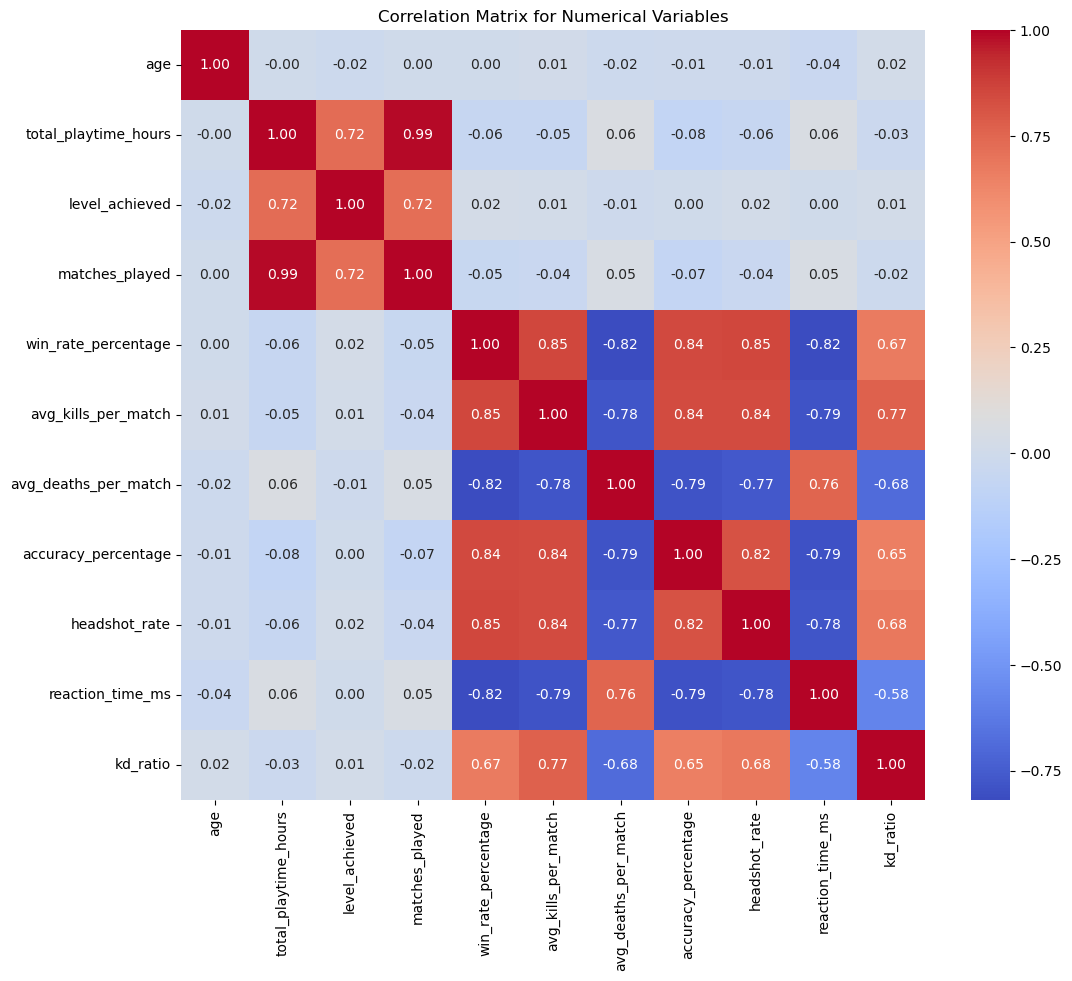

In [23]:
plt.figure(figsize = (12,10))
corr = df.select_dtypes(include = ['number']).corr()
sns.heatmap(corr, annot = True, fmt = '.2f', cmap = 'coolwarm')
plt.title('Correlation Matrix for Numerical Variables')
plt.show()

## Clustering (K-means) for Segmentation of Players

K-means clustering is ideal for grouping players according to their level of experience and playing style. This unsupervised algorithm can identify natural patterns in behavioral data without prior labeling.

In [24]:
features = ['win_rate_percentage', 'avg_kills_per_match', 'avg_deaths_per_match',
             'accuracy_percentage', 'headshot_rate', 'reaction_time_ms', 'kd_ratio']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [25]:
df['gender'] = LabelEncoder().fit_transform(df['gender'])
df['country'] = LabelEncoder().fit_transform(df['country'])

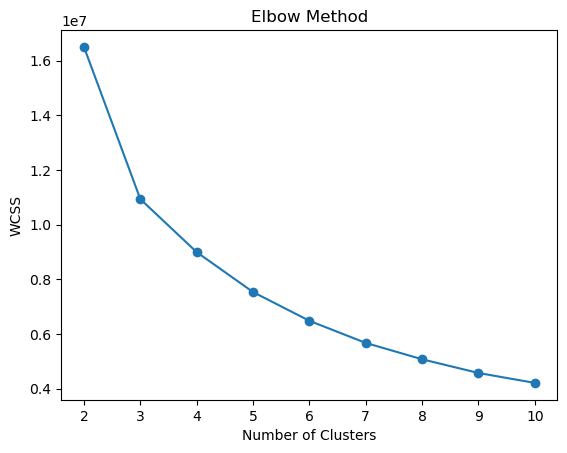

In [26]:
wcss = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 11), wcss, marker = 'o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [27]:
kmeans = KMeans(n_clusters = 5, random_state = 42)
clusters = kmeans.fit_predict(X_scaled)
df['cluster'] = clusters
pal = sns.color_palette('husl', 5)

<Axes: xlabel='cluster', ylabel='count'>

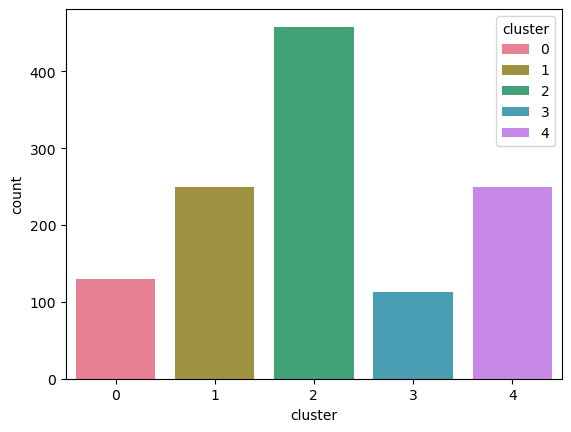

In [28]:
sns.countplot(x = 'cluster', data = df, hue = 'cluster', palette = pal)

In [29]:
def cluster_graph(x_name, x_label, suptitle):
    fig, axs = plt.subplots(ncols = 5, figsize = (25, 6), sharex = True, sharey = True)

    for i in range(5):
        axs[i].set_title(f'Cluster {i}', fontsize = 14)
        cluster_data = df[df.cluster == i][x_name]

        data_range = cluster_data.max() - cluster_data.min()
        binwidth = data_range / 20

        sns.histplot(
            data = cluster_data,
            color = pal[i],
            binwidth = binwidth if binwidth > 0 else 0.1,
            ax = axs[i],
            kde = True
        )
        axs[i].set_xlabel(x_label)
        axs[i].set_ylabel('Frequency')

    plt.suptitle(suptitle, fontsize = 18, y = 1.05)
    plt.tight_layout()
    plt.show()

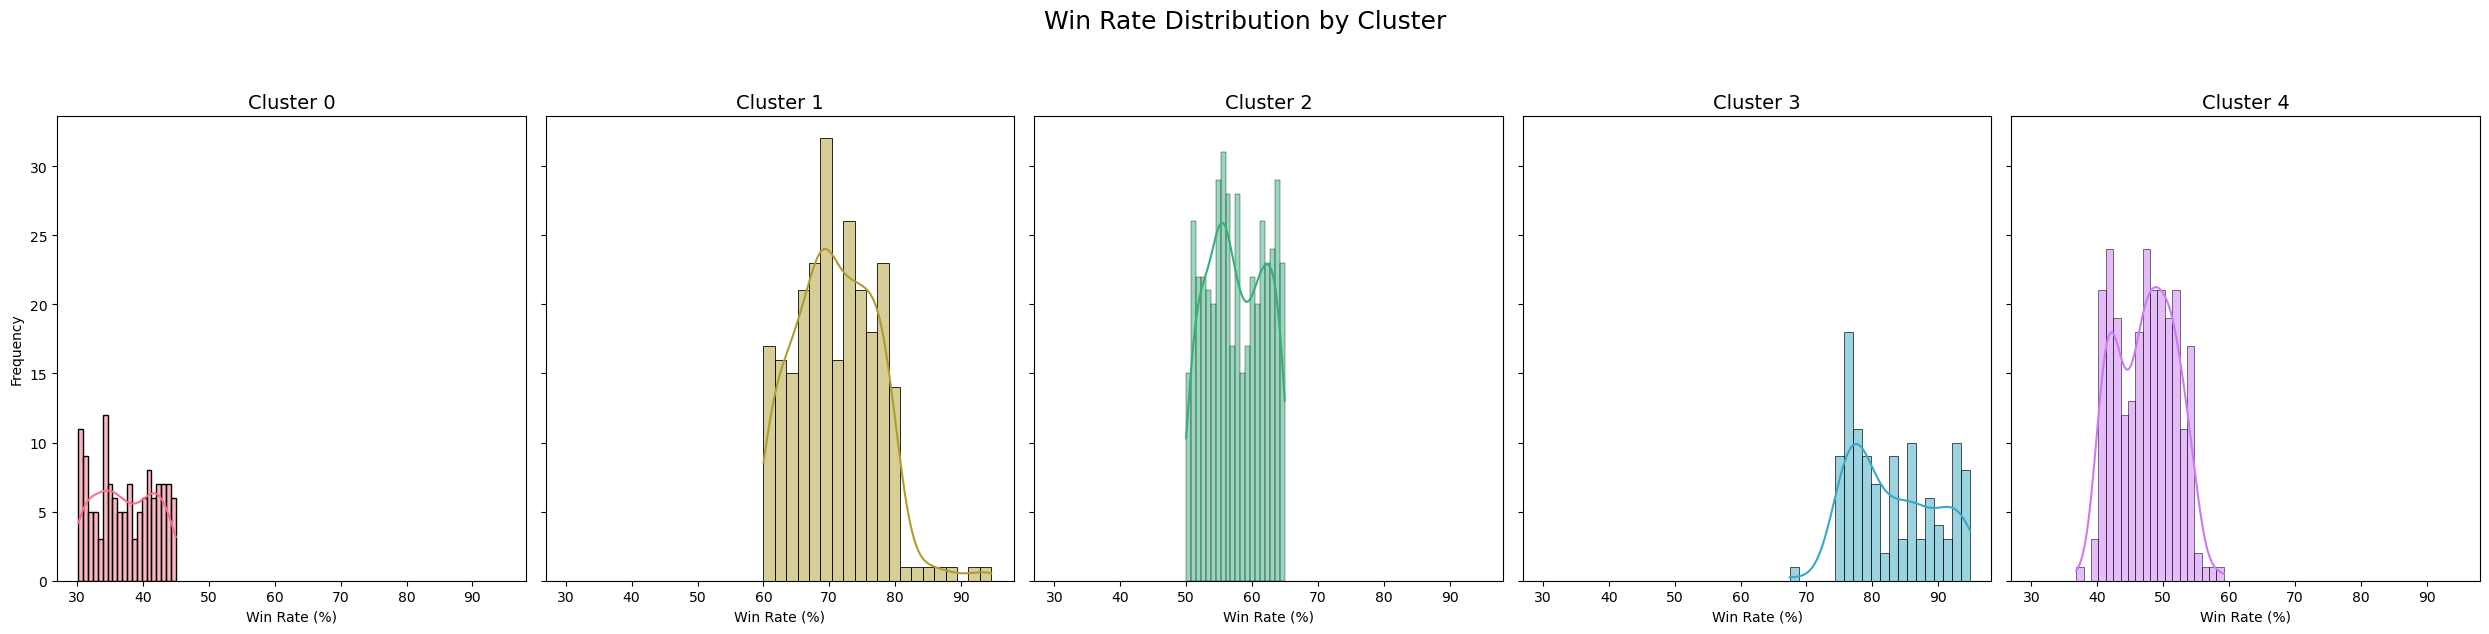

In [30]:
cluster_graph('win_rate_percentage', 'Win Rate (%)', 'Win Rate Distribution by Cluster')

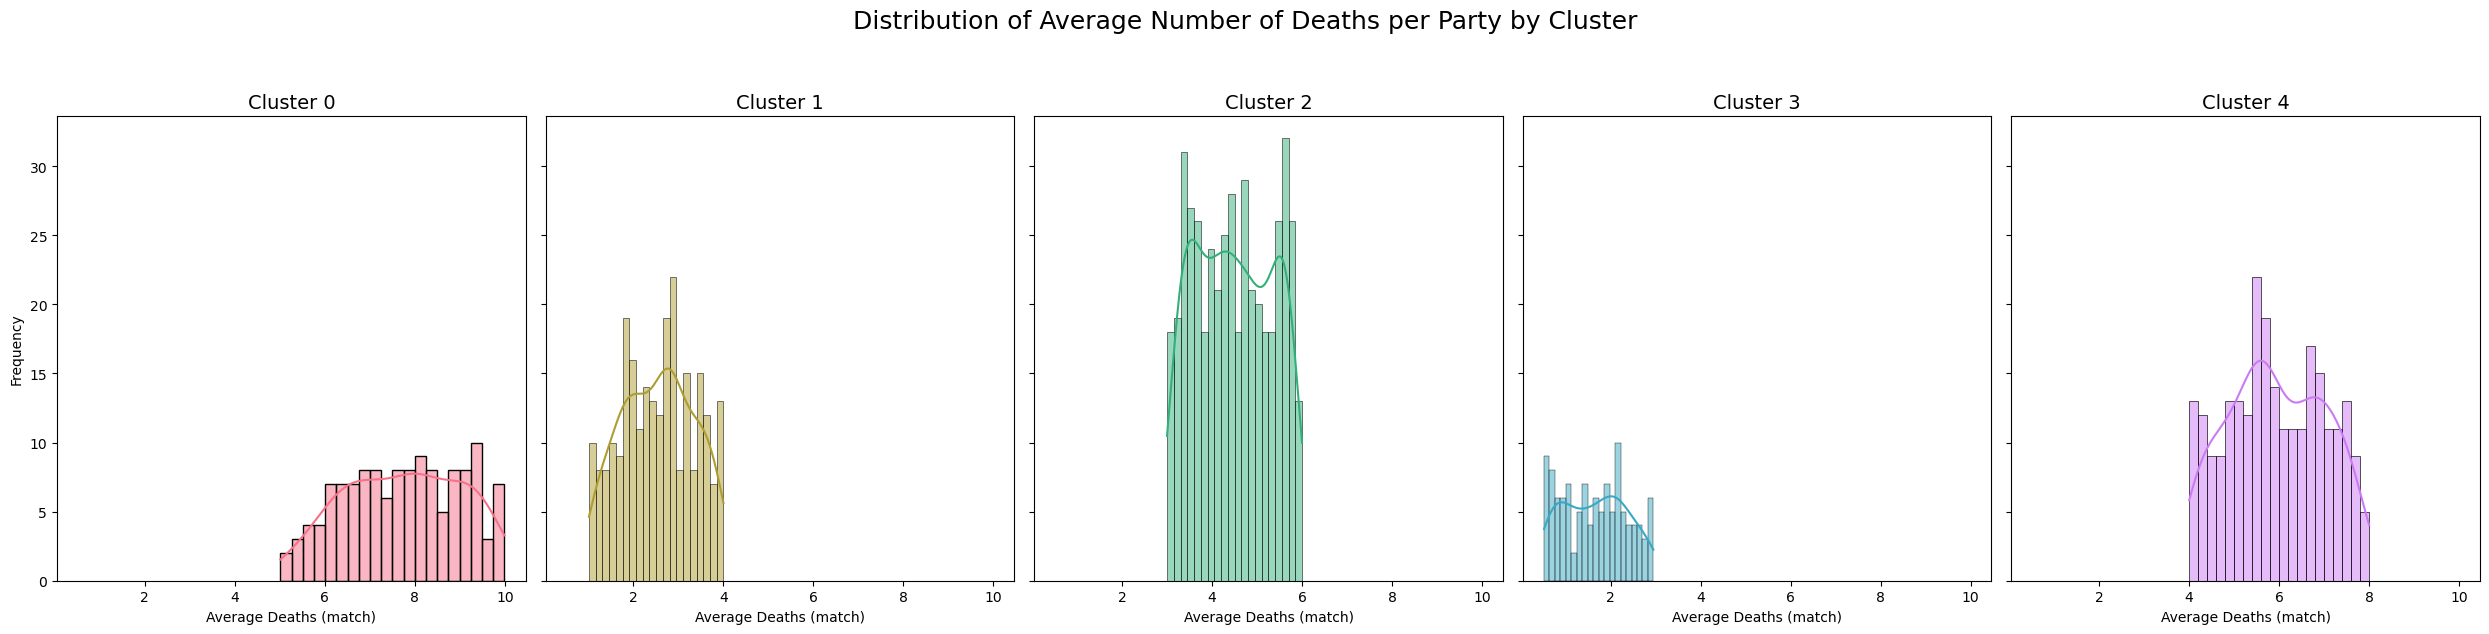

In [31]:
cluster_graph('avg_deaths_per_match', 'Average Deaths (match)', 'Distribution of Average Number of Deaths per Party by Cluster')

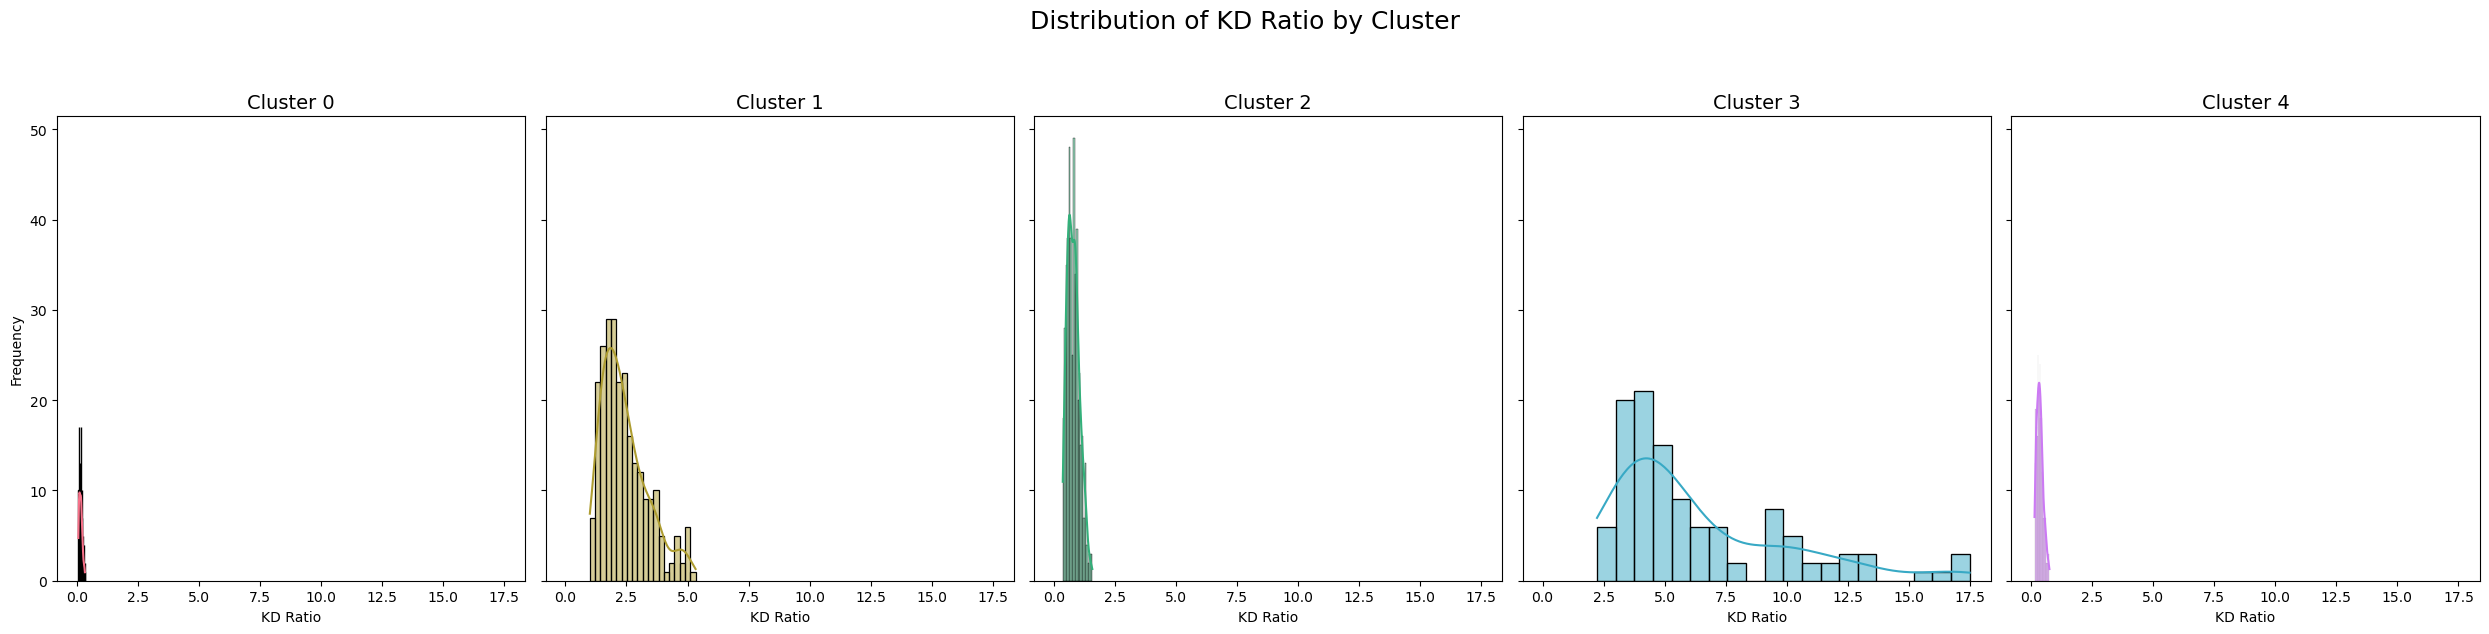

In [32]:
cluster_graph('kd_ratio', 'KD Ratio', 'Distribution of KD Ratio by Cluster')

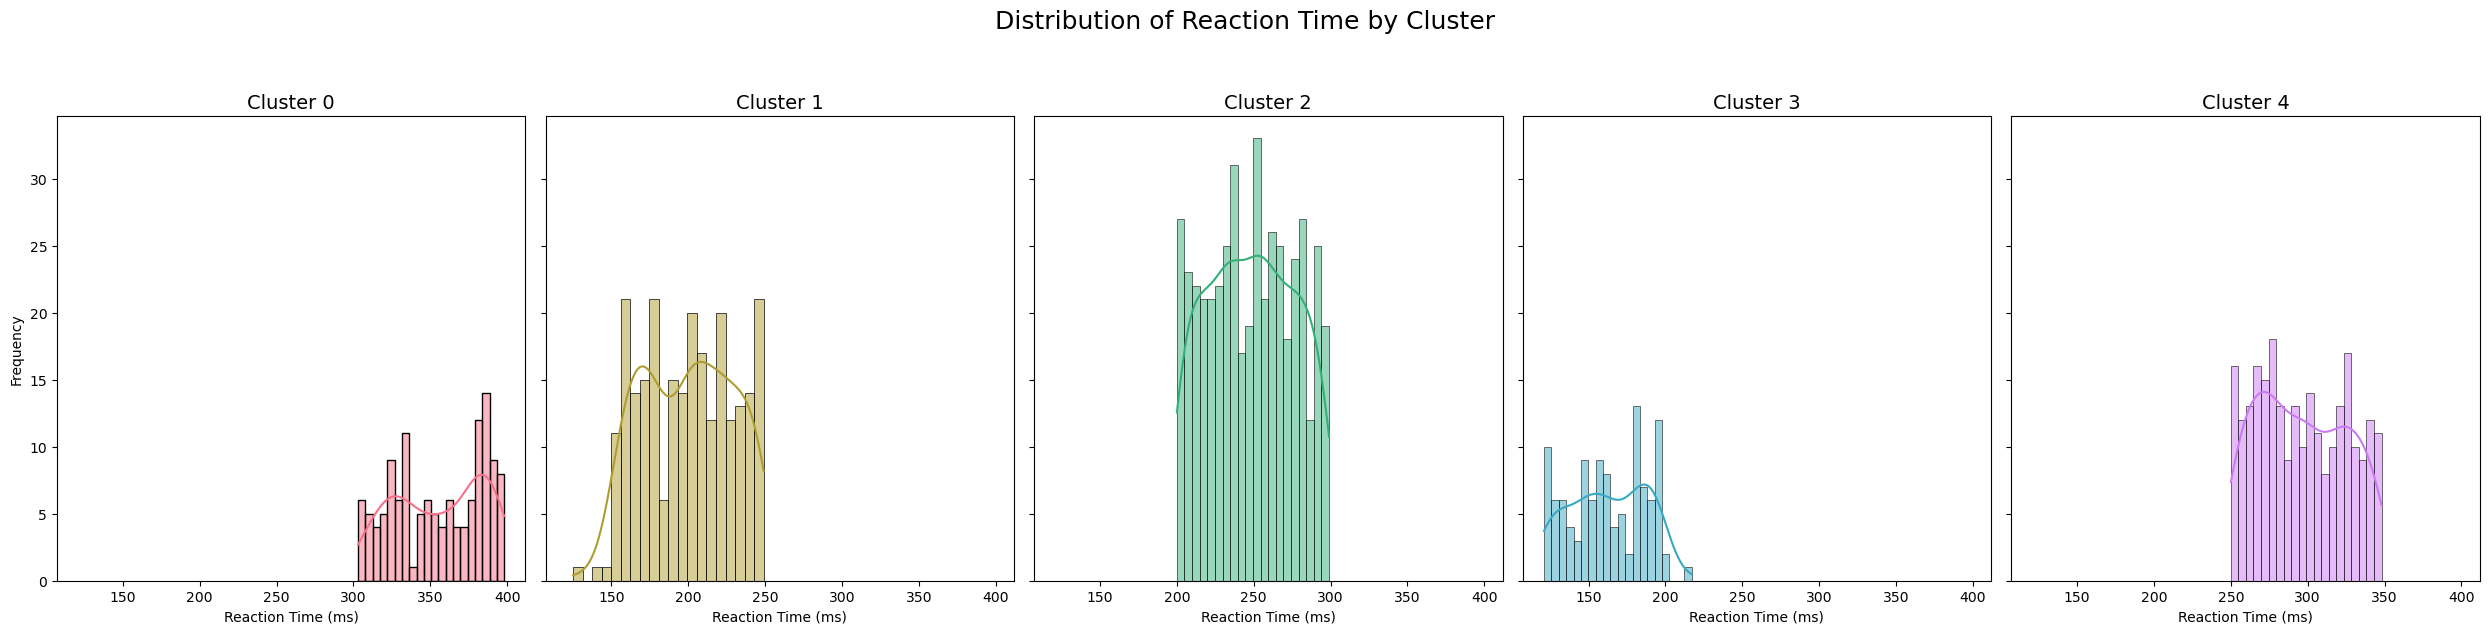

In [33]:
cluster_graph('reaction_time_ms', 'Reaction Time (ms)', 'Distribution of Reaction Time by Cluster')

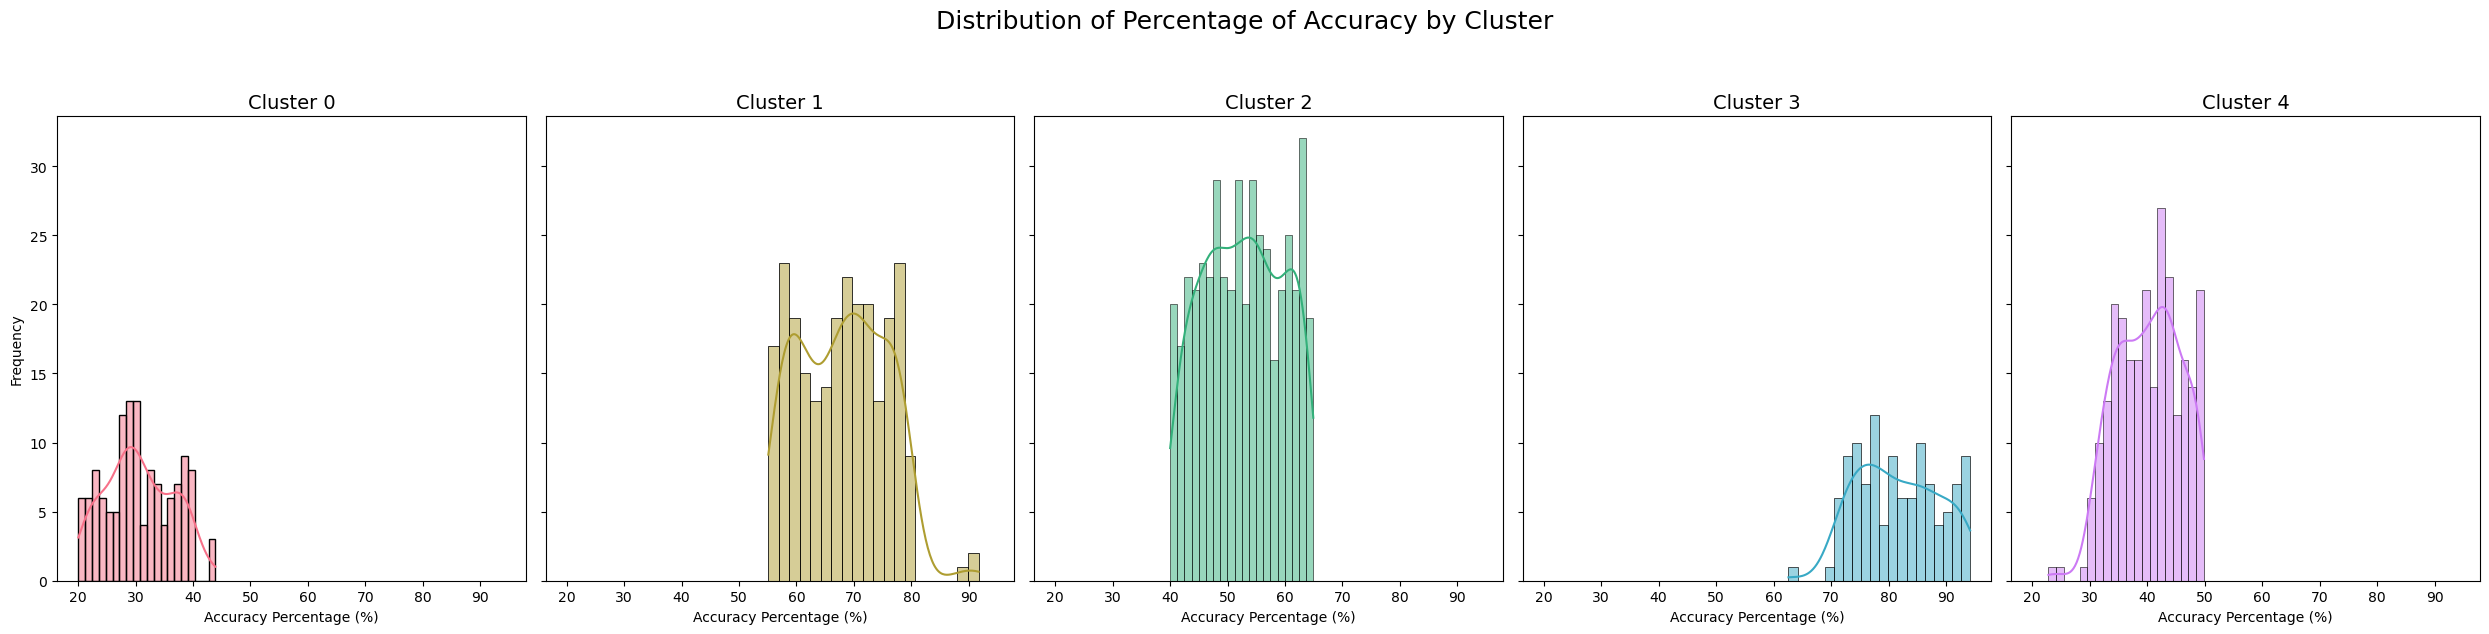

In [34]:
cluster_graph('accuracy_percentage', 'Accuracy Percentage (%)', 'Distribution of Percentage of Accuracy by Cluster')

In [35]:
cluster_summary = df.groupby('cluster')[features].mean()
print(cluster_summary)

         win_rate_percentage  avg_kills_per_match  avg_deaths_per_match  \
cluster                                                                   
0                  37.259154             1.182769              7.735923   
1                  70.984618             5.501044              2.545060   
2                  57.618493             3.426310              4.479083   
3                  83.051947             8.305221              1.646637   
4                  47.290440             2.048720              5.932320   

         accuracy_percentage  headshot_rate  reaction_time_ms  kd_ratio  
cluster                                                                  
0                  30.627154       6.656000        355.307692  0.157000  
1                  67.961205      27.700321        199.208835  2.420201  
2                  52.734127      17.257598        248.491266  0.795022  
3                  81.587168      37.701858        162.486726  6.371150  
4                  40.272480  

__Cluster 0:__ Novice Players
* Low performance: Lower win rate (37.26%).
* High risk: Higher kill rate (7.74/match).
* Slow reaction: 355ms reaction time.
* Strategy: Interactive tutorials, reduced difficulty, gameplay assistance.

__Cluster 1:__ Proficient Players
* Solid performance: Win rate 70.98% and K/D 2.42.
* Average accuracy: 67.96% accuracy.
* Potential: Could improve with specific challenges.
* Strategy: Balanced difficulty, accuracy challenges.

__Cluster 2:__ Average Players
* Balanced performance: All metrics at average values.
* Opportunity: Greater potential for improvement with guidance.
* Strategy: Gradual challenges, mentoring system.

__Cluster 3:__ Elite Players
* Excellence: Maximum win rate (83.05%) and K/D (6.37).
* Exceptional accuracy: 81.59% accuracy.
* Fast reaction: 162ms (best of all).
* Strategy: Hardcore modes.

__Cluster 4:__ Inconsistent Players
* Untapped potential: Good eliminations (2.05) but high mortality (5.93).
* Improvable accuracy: 40.27% accuracy.
* Strategy: Specific training, game analysis.

## Random Forest for Difficulty Adjustment
Random Forest is ideal for dynamically challenging systems because of its ability to handle nonlinear relationships between performance variables (K/D ratio, win rate, accuracy) and tuning decisions (raise / hold / lower). Its robustness to noise and unbalanced data makes it superior to neural networks in scenarios with limited data.

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

if 'recommended_difficulty' not in df.columns:
    df['skill_score'] = (df['win_rate_percentage'] * 5 +
                         df['kd_ratio'] * 2 +
                         df['accuracy_percentage'] * 0.2 +
                         df['headshot_rate'] * 0.1)
    percentiles = np.percentile(df['skill_score'], [25, 58, 87])
    df['recommended_difficulty'] = np.select(
        [df['skill_score'] < percentiles[0],
         df['skill_score'] < percentiles[1],
         df['skill_score'] < percentiles[2]],
        ['Easy', 'Medium', 'Hard'],
        'Expert'
    )

features = df[['win_rate_percentage', 'avg_kills_per_match', 'avg_deaths_per_match',
             'accuracy_percentage', 'headshot_rate', 'reaction_time_ms', 'kd_ratio']]

np.random.seed(42)

difficulty_map = ['Easy', 'Medium', 'Hard', 'Expert']
df['current_difficulty'] = np.random.choice(difficulty_map, size = len(df))

def calculate_action(row):
    performance_ratio = min(1, max(0, 
        (row['win_rate_percentage']/100 + 
         row['kd_ratio']/5 + 
         row['accuracy_percentage']/100) / 3
    ))
    
    lower_threshold = 0.4
    upper_threshold = 0.7
    
    difficulty_levels = ['Easy', 'Medium', 'Hard', 'Expert']
    recommended = row['recommended_difficulty']
    current = row['current_difficulty']
    recommended_idx = difficulty_levels.index(recommended)
    current_idx = difficulty_levels.index(current)
    
    if performance_ratio < lower_threshold and current_idx > 0:
        return 'decrease'
    elif performance_ratio > upper_threshold and current_idx < len(difficulty_levels) - 1:
        return 'increase'
    else:
        return 'maintain'


df['difficulty'] = df.apply(calculate_action, axis = 1)

df.head()

,age,gender,country,total_playtime_hours,level_achieved,matches_played,win_rate_percentage,avg_kills_per_match,avg_deaths_per_match,accuracy_percentage,headshot_rate,reaction_time_ms,kd_ratio,cluster,skill_score,recommended_difficulty,current_difficulty,difficulty
0,58,0,1,230,100,475,54.56,4.43,3.88,51.16,20.91,269.0,1.14,2,287.403,Medium,Hard,maintain
1,47,0,6,79,92,130,94.75,6.90,2.16,85.24,43.73,132.0,3.19,3,501.551,Expert,Expert,maintain
2,60,1,9,20,46,71,75.04,5.70,1.82,66.86,25.01,207.0,3.13,1,397.333,Hard,Easy,maintain
3,27,0,1,33,54,65,63.34,3.71,4.90,52.97,10.77,223.0,0.76,2,329.891,Hard,Hard,maintain
4,19,1,1,137,100,279,47.38,1.62,4.73,40.08,8.23,275.0,0.34,4,246.419,Easy,Hard,decrease


In [37]:
features = df[['win_rate_percentage', 'avg_kills_per_match', 'avg_deaths_per_match',
             'accuracy_percentage', 'headshot_rate', 'reaction_time_ms', 'kd_ratio']]

In [38]:
le = LabelEncoder()
df['difficulty_encoded'] = le.fit_transform(df['difficulty'])

In [39]:
print(df['difficulty_encoded'].value_counts())

difficulty_encoded
2    723
0    369
1    108
Name: count, dtype: int64


In [40]:
X = features
y = df['difficulty_encoded']

smote = SMOTE(random_state = 42)
X_res, y_res = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state = 42, shuffle = True)

In [41]:
rf = RandomForestClassifier(
    n_estimators = 200,
    max_depth = 10,
    min_samples_split = 5,
    class_weight = 'balanced',
    random_state = 42
)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=5, n_estimators=200, random_state=42)

In [42]:
y_pred = rf.predict(X_test)

report = classification_report(
    y_test, y_pred,
    target_names =['Decrease', 'Increase', 'Maintain']
)

print(report)

              precision    recall  f1-score   support

    Decrease       0.85      0.98      0.91       148
    Increase       0.94      1.00      0.97       147
    Maintain       0.97      0.76      0.85       139

    accuracy                           0.91       434
   macro avg       0.92      0.91      0.91       434
weighted avg       0.92      0.91      0.91       434



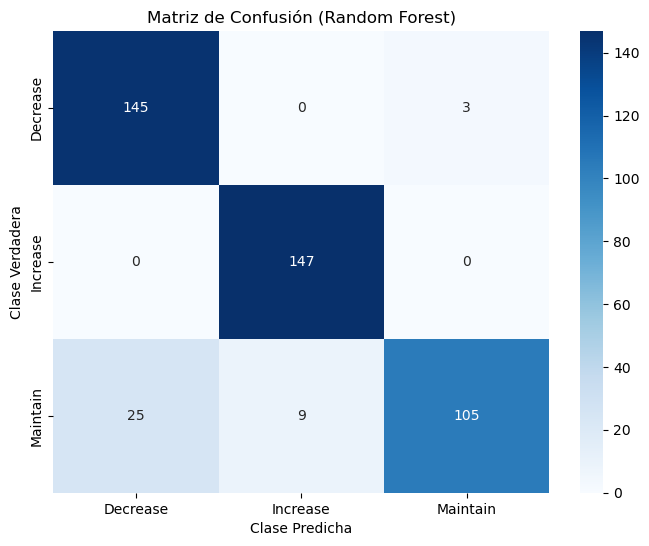

In [43]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (8,6))
sns.heatmap(
    conf_matrix, 
    annot = True, 
    fmt = 'd', 
    cmap = 'Blues',
    xticklabels = ['Decrease', 'Increase', 'Maintain'],
    yticklabels = ['Decrease', 'Increase', 'Maintain']
)

plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión (Random Forest)')
plt.show()

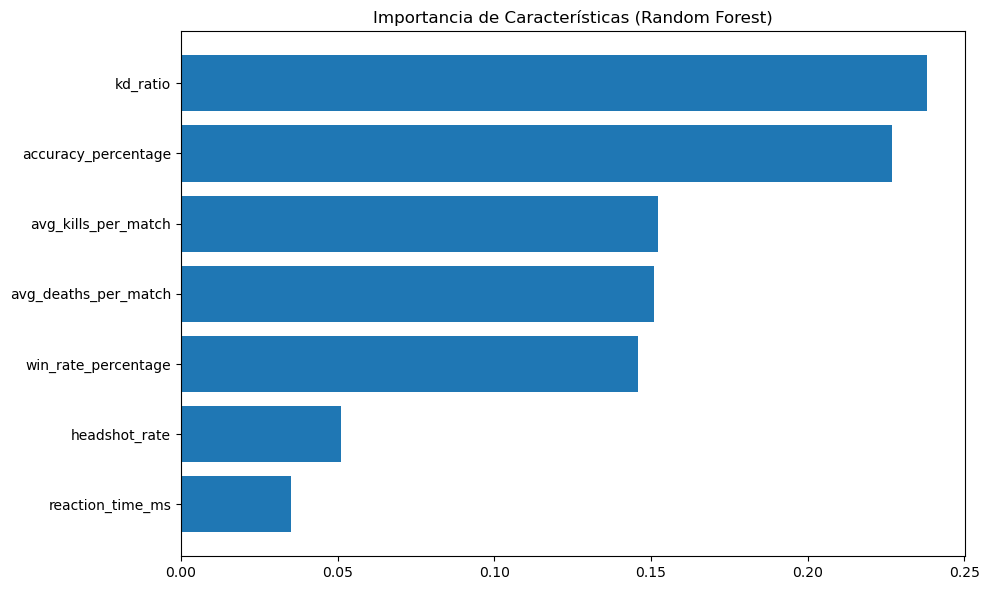

In [44]:
importances = rf.feature_importances_
feature_names = features.columns

sorted_idx = np.argsort(importances)
plt.figure(figsize = (10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align = 'center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.title('Importancia de Características (Random Forest)')
plt.tight_layout()
plt.show()

The model achieves 91% overall accuracy and an average F1-score of 0.91, demonstrating high effectiveness in deciding difficulty changes in real time. 
This exceeds the 85% threshold considered optimal for DDA systems on industry.

The model correctly adjusts difficulty in 9 out of 10 cases, keeping players in a flow state. In addition, it prioritizes avoiding gross errors (not raising when it should) over false positives.

Therefore, Random Forest proves to be robust, efficient and highly applicable for difficulty adaptivity systems, with an overall performance of 91% that meets industry standards.